## Example use: impact modelling - solar energy generation

Author: Karin van der Wiel, 12-07-2022

PV energy model from: Van der Wiel et al. (2019, RSER, http://doi.org/10.1016/j.rser.2019.04.065).

Aim of the case study: show the advantage of large ensemble modelling also for climate-impact studies.

#### Preparation

In [1]:
## import packages
from dask.distributed import Client
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

directory='/net/pc200021/nobackup_1/users/muntjewe/LENTIS/ec-earth/cmorised_by_var/'

def sel_point(ds):
    """ Select single grid point """
    lat = 52
    lon = 5
    return ds.sel(lat=lat,lon=lon, method="nearest")
def open_data_LENTIS(var,ensemble,preproc):
    """ Open LENTIS ensemble data """
    if ensemble == 'PD':    exp_name = 'hxxx'
    elif ensemble == '2K':  exp_name = 'sxxx'
    ds = xr.open_mfdataset(f"{directory}{exp_name}/day/{var}/h011*/{var}/gr/*/*.nc",preprocess=preproc,combine='nested',concat_dim='ens',chunks=-1,parallel=False)
    return ds
def daily_annual_cycle(da,rm):
    """ Compute daily mean climatology (taking into account leap days) """
    # compute climatology
    month_day_str = xr.DataArray(da.indexes['time'].strftime('%m-%d'),coords=da.coords,name='month_day_str')
    da_clim = da.groupby(month_day_str).mean('time')
    da_clim = da_clim.rename({'month_day_str':'time'})
    clim_timeaxis = pd.date_range(start='1/1/2000', end='31/12/2000', freq='D').astype('datetime64[ns]')
    da_clim = da_clim.assign_coords({'time':clim_timeaxis})
    # apply running mean
    da_clim_thrice = np.tile(da_clim.values,3)
    da_clim[:] = np.convolve(da_clim_thrice, np.ones(rm)/rm, mode='full')[len(da_clim):2*len(da_clim)]
    return da_clim

import warnings
warnings.filterwarnings("ignore")

#### Solar energy model

In [2]:
# Model constants
cT_c1 = 4.3     # constant [dC]
cT_c2 = 0.943   # constant [-]
cT_c3 = 0.028   # constant [dC m2 W-1]
cT_c4 = -1.528  # constant [dC s m-1]
gamma = -0.005  # constant [--]
t_ref = 25      # reference temperature [dC]
pi = np.pi
kelvin = 273.15 # Kelvin to degrees Celsius
Gstc = 1000     # standard test conditions [W m-2]
shift_doy = 186 # if 360-day calendar : 180

# Functions
def day_length(da):
    """ 
    Aim: Computes the number of daylight hours at locations and times for a given dataset
    """
    day_of_year = da.time.dt.dayofyear
    lat = da.lat
    p = 0. 
    P = np.arcsin(0.39795 * np.cos(0.2163108 + 2 * np.arctan(0.9671396 * np.tan(0.00860*(day_of_year-shift_doy)))))
    arg = ((np.sin(p*pi/180) + np.sin(lat*pi/180) * np.sin(P)) / (np.cos(lat*pi/180) * np.cos(P)))
    arg = xr.where(arg < -1, -1, arg)
    arg = xr.where(arg > 1, 1, arg)
    da_daylight_hours = 24 - 24/pi * np.arccos(arg)
    return da_daylight_hours
def solar_cell_temp(da_rsds, da_tas, da_tasmax, da_wind):
    """
    Aim: Computes solar cell temperature
    """
    da_tasday = (da_tas + da_tasmax)/2
    da_cell_temp = cT_c1 + cT_c2*da_tasday + cT_c3**da_rsds + cT_c4*da_wind
    return da_cell_temp
def solar_perf_ratio(da_cell_temp):
    """
    Aim: Computes performance ratio of the solar cell
    """
    da_pr = 1 + gamma*(da_cell_temp-t_ref)
    return da_pr
def solar_potential(da_pr,da_rsds):
    """
    Aim: Computes theoretical solar power potential 
    """
    da_pot = da_pr * da_rsds / Gstc    
    return da_pot
def compute_solar_energy_production(da_rsds,da_tas,da_tasmax,da_wind):
    """
    Aim: Main solar energy computation function, here stopped at the computation of potentials [fraction] rather than actual production [TWh/day]. 
    """
    # compute daylight hours [h/d]
    da_daylight_hours = day_length(da_tas)
    # correct radiation for daylight hours [W m-2]
    da_rsds_day = da_rsds * 24 / da_daylight_hours
    da_rsds_day = xr.where(da_daylight_hours==0, 0, da_rsds_day)
    # unit conversion [degC]
    da_tas = da_tas - kelvin
    da_tasmax = da_tasmax - kelvin
    # compute cell temperature
    da_cell_temp = solar_cell_temp(da_rsds_day, da_tas, da_tasmax, da_wind)
    # compute performance ratio
    da_PR = solar_perf_ratio(da_cell_temp)
    # compute potential [0-1]
    da_solar_pot = solar_potential(da_PR, da_rsds_day)
    da_solar_pot.name = 'PVpot'
    da_solar_pot.attrs = da_rsds.attrs
    da_solar_pot.attrs['units'] = ''
    """
    # compute capacity factors [0-1 h]
    da_solar_cf = da_solar_pot * da_daylight_hours
    # compute production
    da_solar_prod = (da_solar_cf * da_solar_distr) /10**6
    da_solar_prod.id = 'solar'
    da_solar_prod.units = 'TWh d**-1'
    da_solar_prod.long_name = 'Solar energy production'"""
    # done
    return da_solar_pot

#### Open LENTIS data

In [3]:
da_tas = open_data_LENTIS('tas','PD',sel_point)['tas']
da_tasmax = open_data_LENTIS('tasmax','PD',sel_point)['tasmax']
da_rsds = open_data_LENTIS('rsds','PD',sel_point)['rsds']
da_wind = open_data_LENTIS('sfcWind','PD',sel_point)['sfcWind']

# fix ensemble dimension (TEMPORARY, ONLY WORKS FOR 1 MEMBER!!)
da_tas = da_tas.max(dim='ens')
da_tasmax = da_tasmax.max(dim='ens')
da_rsds = da_rsds.max(dim='ens')
da_wind = da_wind.max(dim='ens')

da_tas.load(); da_tasmax.load(); da_rsds.load(); da_wind.load()

<xarray.DataArray 'sfcWind' (time: 3653)>
array([ 8.347963 , 13.185693 , 14.269354 , ...,  3.440714 ,  5.0300627,
        4.0704136], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T12:00:00 ... 2009-12-31T12:00:00
    lat      float64 52.28
    lon      float64 4.922
    height   float64 10.0

#### Computation

In [4]:
# Compute impact variable
da_solar_pot = compute_solar_energy_production(da_rsds,da_tas,da_tasmax,da_wind)
da_tas_day = (da_tas + da_tasmax)/2

# Find events: maximum production
N = 10
da_solar_pot_thresh = np.sort(da_solar_pot.values)[-1*(N+1):-1*(N-1)].mean()
da_solar_pot_extr = da_solar_pot.where(da_solar_pot>da_solar_pot_thresh)

da_rsds_thresh = np.sort(da_rsds.values)[-1*(N+1):-1*(N-1)].mean()
da_rsds_extr = da_rsds.where(da_rsds>da_rsds_thresh)

"""# Only show DJF-JJA
def sel_months(da):
    mask_winter = da.where(da.time.dt.season=='DJF')
    mask_summer = da.where(da.time.dt.season=='JJA')
    da_mask = xr.concat([mask_winter,mask_summer],dim='time')
    da_mask = da_mask.dropna(dim='time')
    return da_mask
da_solar_pot = sel_months(da_solar_pot)
da_rsds = sel_months(da_rsds)
da_tas_day = sel_months(da_tas_day)
da_wind = sel_months(da_wind)"""

"# Only show DJF-JJA\ndef sel_months(da):\n    mask_winter = da.where(da.time.dt.season=='DJF')\n    mask_summer = da.where(da.time.dt.season=='JJA')\n    da_mask = xr.concat([mask_winter,mask_summer],dim='time')\n    da_mask = da_mask.dropna(dim='time')\n    return da_mask\nda_solar_pot = sel_months(da_solar_pot)\nda_rsds = sel_months(da_rsds)\nda_tas_day = sel_months(da_tas_day)\nda_wind = sel_months(da_wind)"

#### Plot figure

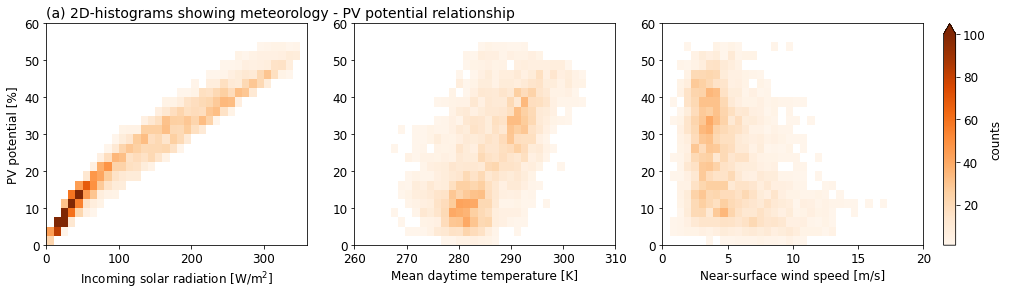

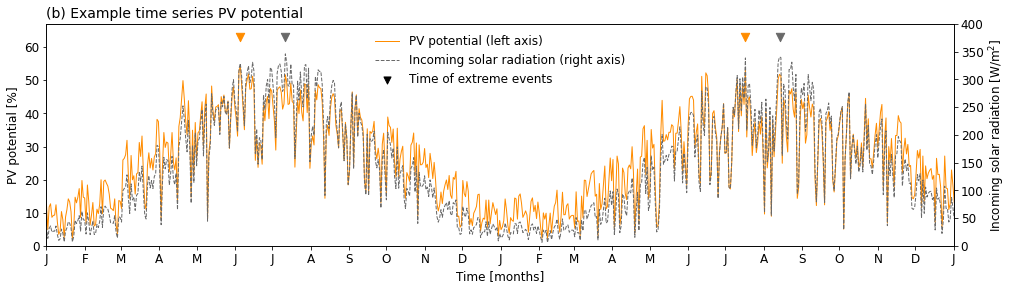

In [5]:
fig = plt.figure(figsize=(14,4))
plt.subplots_adjust(left=0.05, bottom=0.13, right=.92, top=0.9, wspace=0.18)
MAX = 100
# 2D histogram/scatter plot: solar vs rsds
ax = plt.subplot(1,3,1)
plt.hist2d(da_rsds,da_solar_pot*100,cmap='Oranges',range=[[0,360],[0,60]],bins=(36,24),norm=colors.Normalize(vmax=MAX),cmin=1) # colors.LogNorm
plt.title('(a) 2D-histograms showing meteorology - PV potential relationship',loc='left',fontsize=14)
plt.xlabel('Incoming solar radiation [W/m$^2$]',fontsize=12)
plt.ylabel('PV potential [%]',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
# solar vs TASday
ax = plt.subplot(1,3,2)
plt.hist2d(da_tas_day,da_solar_pot*100,cmap='Oranges',range=[[260,310],[0,60]],bins=(36,24),norm=colors.Normalize(vmax=MAX),cmin=1)
plt.xlabel('Mean daytime temperature [K]',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
# solar vs wind
ax = plt.subplot(1,3,3)
im = plt.hist2d(da_wind,da_solar_pot*100,cmap='Oranges',range=[[0,20],[0,60]],bins=(36,24),norm=colors.Normalize(vmax=MAX),cmin=1)
plt.xlabel('Near-surface wind speed [m/s]',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
cbar_ax = fig.add_axes([.94,0.13,.012,.77]) #xpos,ypos,xlen,ylen
cbar = plt.colorbar(orientation='vertical',extend='max',cax=cbar_ax)
cbar.set_label('counts', rotation=90, fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.savefig(f"fig_example_impact_PV_a.pdf")

fig,ax1 = plt.subplots(figsize=(14,4))
plt.subplots_adjust(left=0.05, bottom=0.13, right=.95, top=0.9)
colour1 = 'darkorange'
colour2 = 'dimgrey'
# line1
ax1.plot(np.arange(0,11,11/3653),da_solar_pot*100,color=colour1,linewidth=1,label='PV potential (left axis)')
# events
ax1.scatter(np.arange(0,11,11/3653),da_solar_pot_extr/da_solar_pot_extr*63,color=colour1,marker='v',s=70)
ax1.scatter(np.arange(0,11,11/3653),da_rsds_extr/da_rsds_extr*63,color=colour2,marker='v',s=70)
plt.ylim(0,67)
plt.title('(b) Example time series PV potential',loc='left',fontsize=14)
plt.xlabel('Time [months]',fontsize=12)
plt.ylabel('PV potential [%]',fontsize=12)#,color=colour1)
# line2
ax2 = ax1.twinx()
ax2.plot([-10],[0],color=colour1,linewidth=1,label='PV potential (left axis)') # fake for legend
ax2.plot(np.arange(0,11,11/3653),da_rsds,color=colour2,linewidth=1,linestyle='--',label='Incoming solar radiation (right axis)')
ax2.scatter([-10],[0],color='black',marker='v',s=50,label='Time of extreme events') # fake for legend
plt.ylabel('Incoming solar radiation [W/m$^2$]',fontsize=12)#,color=colour2)
plt.ylim(0,400)
# annotation etc
plt.xticks(np.arange(0,10.0000001,10/3653)[np.where(da_rsds.time.dt.day==1)[0][0:25]],'JFMAMJJASONDJFMAMJJASONDJ')
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
plt.xlim(0,np.arange(0,10.0000001,10/3653)[np.where(da_rsds.time.dt.day==1)[0][24]])
plt.legend(frameon=False,fontsize=12)
plt.savefig(f"fig_example_impact_PV_b.pdf")

plt.show()